In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from auto_deploy.predictor import Predictor
import os
import json
import lmdb
import cv2
import numpy as np
import pickle
import io

In [8]:
lmdb_dir = "/world/data-c26/liliang/cleaned_data/cleaned_v9"

In [9]:
lmdb_file = os.path.join(lmdb_dir, "labels2imgs.json")
with open(lmdb_file, 'r') as f:
    labels2imgs = json.loads(f.read())

In [ ]:
train_dataset = LMDBDataset(lmdb_dir)

In [ ]:
gpu = "0"
model_path = "/world/data-gpu-112/liliang/pytorch-output/cleanv9+_resnet50_am035_am0_fixcls_v9/resnet_50_ibn_a_20190723_193423.pt"
input_size = (128, 256)
preprocess_dict = {"norm_lambda": "lambda x: x", "color_mode": "None"}
model = Predictor(gpu=gpu, input_size=input_size, model_path=model_path,
                  preprocess_dict=preprocess_dict)

In [ ]:
feat_dir = "/world/data-c26/kebo/feat_v90"
env = lmdb.open(feat_dir, map_size=1 << 40)

In [ ]:
keys = []
for label, img_paths in labels2imgs.items():
    if int(label) % 5000 == 0 and int(label) != 0:
        print("{}/{}".format(label, len(labels2imgs)))
    inds = []
    imgs = []
    for ind in img_paths:
        img = train_dataset[int(ind)][0]
        img = cv2.cvtColor(np.asarray(img),cv2.COLOR_RGB2BGR)
        inds.append(ind)
        imgs.append(img)
    feats = model.predict(imgs)
    for ind, feat in zip(inds, feats):
        key = "{:08}".format(ind)
        keys.append(key)
        value = {"feature": feat,
                "label": int(label)}
        serialized_string = pickle.dumps(value)
        with env.begin(write=True) as txn:
            txn.put(key.encode(), serialized_string)

with open(os.path.join(feat_dir, "_cache_keys.pkl"), "wb") as f:
    pickle.dump(keys, f)

In [ ]:
plt.imshow(img)

In [ ]:
img = train_dataset[int(ind)][0]

In [ ]:
len(model.predict(imgs))

In [4]:
class LMDBSingle():
    def __init__(self, root, dtype="img"):
        import lmdb
        self.env = lmdb.open(root, max_readers=1, readonly=True, lock=False,
                             readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.length = txn.stat()["entries"]

        with open(os.path.join(root, "_cache_keys.pkl"), "rb") as f:
            self.keys = pickle.load(f, encoding="bytes")
            
        self.dtype = dtype

    def __getitem__(self, index):
        with self.env.begin(write=False) as txn:
            k = self.keys[index]
            k = k.encode() if not isinstance(k, bytes) else k
            buf = txn.get(k)
            obj = pickle.loads(buf)
        if self.dtype == "img":
            img = Image.open(io.BytesIO(obj["image_raw"]))
            if img.mode != "RGB":
                img = img.convert("RGB")
            target = obj["label"]
            if not isinstance(target, list):
                target = int(target)
            # print(obj["filename"])
            return img, target
        else:
            feature = obj["feature"]
            target = obj["label"]
            return feature, target

    def __len__(self):
        return self.length


class LMDBDataset():
    def __init__(self, root, dtype="img"):
        dbs_paths = sorted([p for p in os.listdir(root) if "train_db" in p],
                           key=lambda x: int(x.split("_")[-1]))
        self.dbs = [LMDBSingle(os.path.join(root, p), dtype)
                    for p in dbs_paths]
        self.indices = []
        count = 0
        for db in self.dbs:
            count += len(db)
            self.indices.append(count)
        self.length = count

    def __getitem__(self, index):
        db_idx = 0
        sub = 0
        for ind in self.indices:
            if index < ind:
                break
            db_idx += 1
            sub = ind

        db = self.dbs[db_idx]
        index -= sub
        images, targets = db[index]
        return images, targets

    def __len__(self):
        return self.length

# Clustering

In [2]:
import scipy.cluster.hierarchy as sch

In [5]:
N = 5
max_len = 10
feat_dir = "/world/data-c26/kebo/feat_v9"
feats = LMDBDataset(feat_dir, dtype="feature")
lmdb_dir = "/world/data-c26/liliang/cleaned_data/cleaned_v9"
imgs = LMDBDataset(lmdb_dir)

In [6]:
def _app_dist(feats):
    # compute all appearance distances
    num_seq = len(feats)
    appearance_dist = np.empty((num_seq * (num_seq - 1)) // 2, dtype=np.double)
    k = 0
    for i in range(0, num_seq - 1):
        for j in range(i + 1, num_seq):
            feat_i = np.array(feats[i])
            feat_j = np.array(feats[j])
            feat_i = feat_i / np.linalg.norm(feat_i, axis=0, keepdims=True)
            feat_j = feat_j / np.linalg.norm(feat_j, axis=0, keepdims=True)
            dist_ij = 1. - np.dot(feat_i, feat_j.T)
            dist_ij = max(.0, dist_ij)
            appearance_dist[k] = dist_ij
            k = k + 1
    assert len(appearance_dist) == k

    return appearance_dist

In [ ]:
labels2imgs_cleaned = {}
labels2imgs_deprecated = {}
for label, im_info in labels2imgs.items():
    # if int(label) < 50000:
    #     continue
    if len(im_info) == 1:
        print('dist {} contains 1 item: {}'.format(label, im_info))
        continue
    dist = _app_dist([feats[i][0] for i in im_info])
    if (dist[:] < 0).any():
        raise ValueError('dist {} contains negative distances: {}'.format(label, dist))
    Z = sch.linkage(dist, method="complete")
    num_img = len(im_info)
    if num_img < 20:
        t = 0.8
    elif num_img < 50:
        t = 0.8
    else:
        t = 0.8
    cluster = sch.fcluster(Z, t=t, criterion="distance")
    counts = np.bincount(cluster)
    max_counts = np.argmax(counts)
    max_cluster = [im_info[i] for i, c in enumerate(cluster) if c == max_counts]
    if len(max_cluster) > 5:
        labels2imgs_cleaned[label] = max_cluster
        labels2imgs_deprecated[label] = [im_info[i] for i, c in enumerate(cluster) if c != max_counts]
    else:
        labels2imgs_deprecated[label] = im_info
    # if len(set(cluster)) > 1:
    #     print("{}@{}: {}".format(label, t, cluster))

In [ ]:
labels2imgs_cleaned

In [ ]:
len(labels2imgs)

2


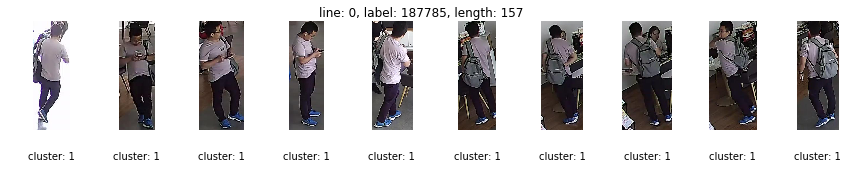

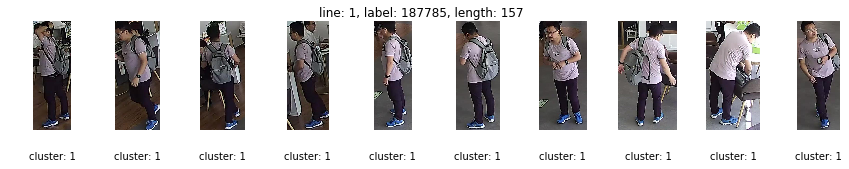

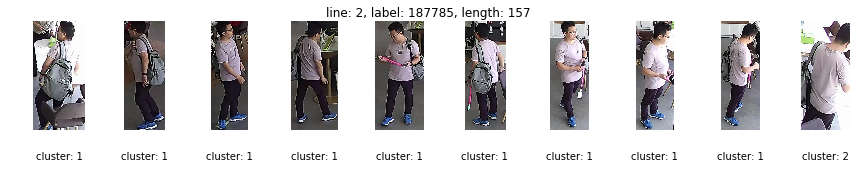

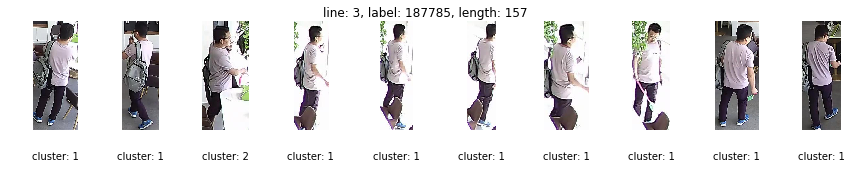

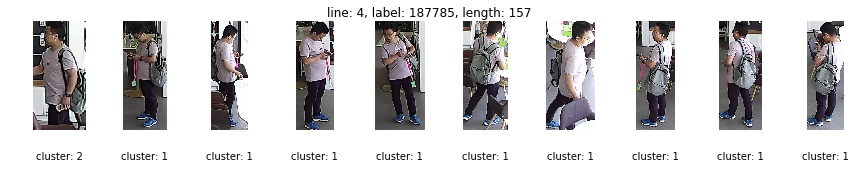

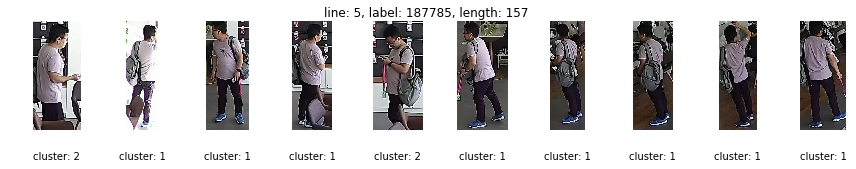

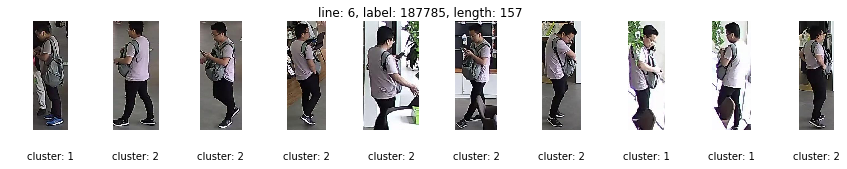

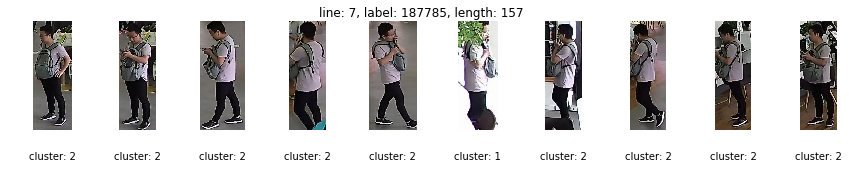

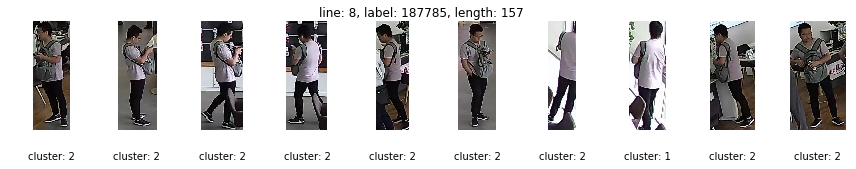

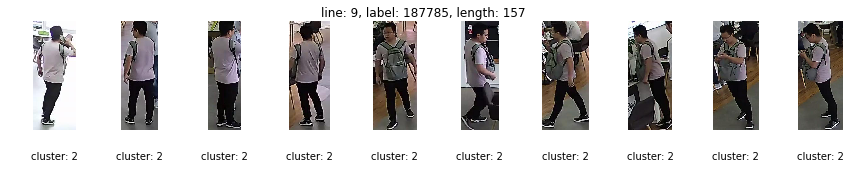

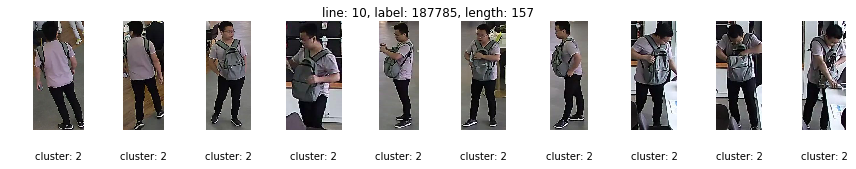

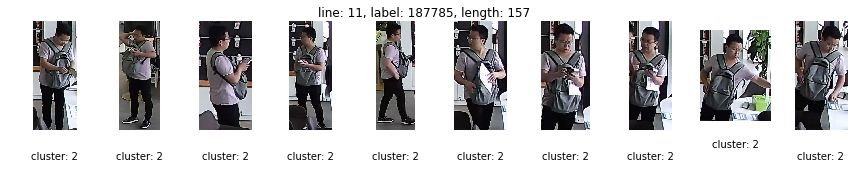

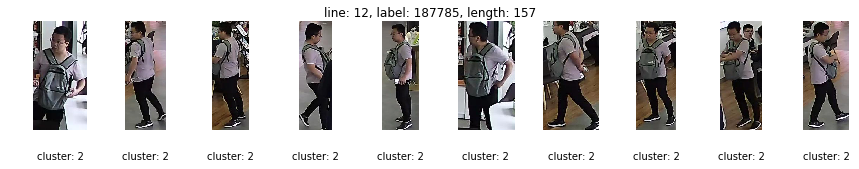

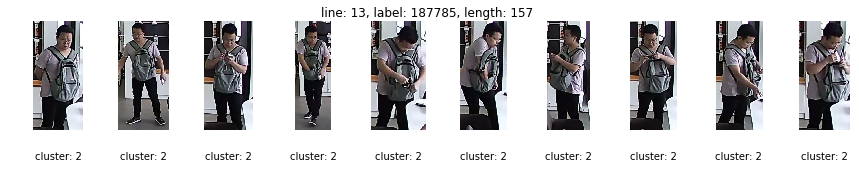

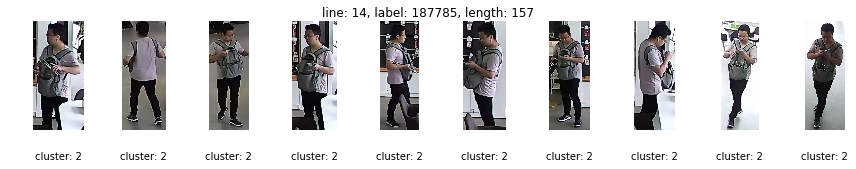

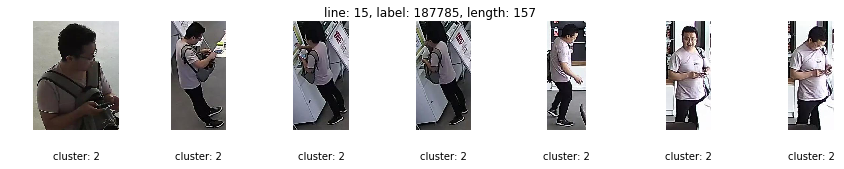

In [23]:
vis_batch(imgs, labels2imgs, '187785', t=0.80)

In [ ]:
rdn_labels = np.random.choice(list(labels2imgs.keys()), size=N, replace=False)
for i, label in enumerate(rdn_labels):
    batch = labels2imgs[label]

In [7]:
def vis_batch(imgs, labels2imgs, key, t=0.7):
    batch = labels2imgs[key]
    dist = _app_dist([feats[i][0] for i in batch])
    if (dist[:] < 0).any():
        raise ValueError('dist contains negative distances: {}'.format(dist))
    Z = sch.linkage(dist, method="complete")
    cluster = sch.fcluster(Z, t=t, criterion="distance")
    counts = np.bincount(cluster)
    print(np.argmax(counts))
    batch = sorted(batch)
    batch_list = [batch[i: i+max_len] for i in range(0, len(batch), max_len)]
    for j, minibatch in enumerate(batch_list):
        plt.figure(j, figsize=(15, 2))
        plt.suptitle("line: " + str(j) + ", label: " + str(key) + ", length: " + str(len(batch)),
                     horizontalalignment='center')
        n = len(minibatch)
        for k, img_idx in enumerate(minibatch):
            plt.subplot(1, n, k+1)
            img = imgs[int(img_idx)][0]
            img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
            plt.imshow(img[:,:,::-1])
            plt.text(img.shape[1] / 2, img.shape[0] * 1.2, "cluster: %s" % cluster[j * max_len + k], verticalalignment="top", horizontalalignment="center")
            plt.axis('off')
        
vis_batch(imgs, labels2imgs, '161')

NameError: name 'labels2imgs' is not defined